# Notebook Model de Machine Learning

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

In [4]:
data = pd.read_csv('../../csv/PreprocessedData.csv')

In [5]:
TARGET = "Email Type"

text_col = "body"

num_cols = data.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]

X_text_raw = data[text_col].fillna("")
X_num = data[num_cols]
y = data[TARGET]


In [6]:
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text_raw,
    X_num,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [7]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2)  # bigrams → améliore les perfs
)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)


In [8]:
scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert numeric to sparse for hstack
X_train_num_sparse = csr_matrix(X_train_num_scaled)
X_test_num_sparse = csr_matrix(X_test_num_scaled)


In [9]:
X_train_final = hstack([X_train_tfidf, X_train_num_sparse])
X_test_final = hstack([X_test_tfidf, X_test_num_sparse])


## Application sur des Modèles

### SVM

In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svm = LinearSVC()
svm.fit(X_train_final, y_train)

print("SVM Results:")
print(classification_report(y_test, svm.predict(X_test_final)))


SVM Results:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2264
           1       0.94      0.97      0.95      1466

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



### XGBoost

In [11]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_final, label=y_train)
dtest = xgb.DMatrix(X_test_final, label=y_test)

xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 6,
    "eta": 0.1,
}

xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=200
)

pred_xgb = (xgb_model.predict(dtest) > 0.5).astype(int)


print("XGBoost Results:")
print(classification_report(y_test, pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2264
           1       0.92      0.97      0.94      1466

    accuracy                           0.96      3730
   macro avg       0.95      0.96      0.95      3730
weighted avg       0.96      0.96      0.96      3730



### CatBoost

In [12]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.1,
    loss_function="Logloss",
    verbose=0
)

cat.fit(X_train_final, y_train)

print("CatBoost Results:")
print(classification_report(y_test, cat.predict(X_test_final)))


CatBoost Results:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2264
           1       0.94      0.97      0.95      1466

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



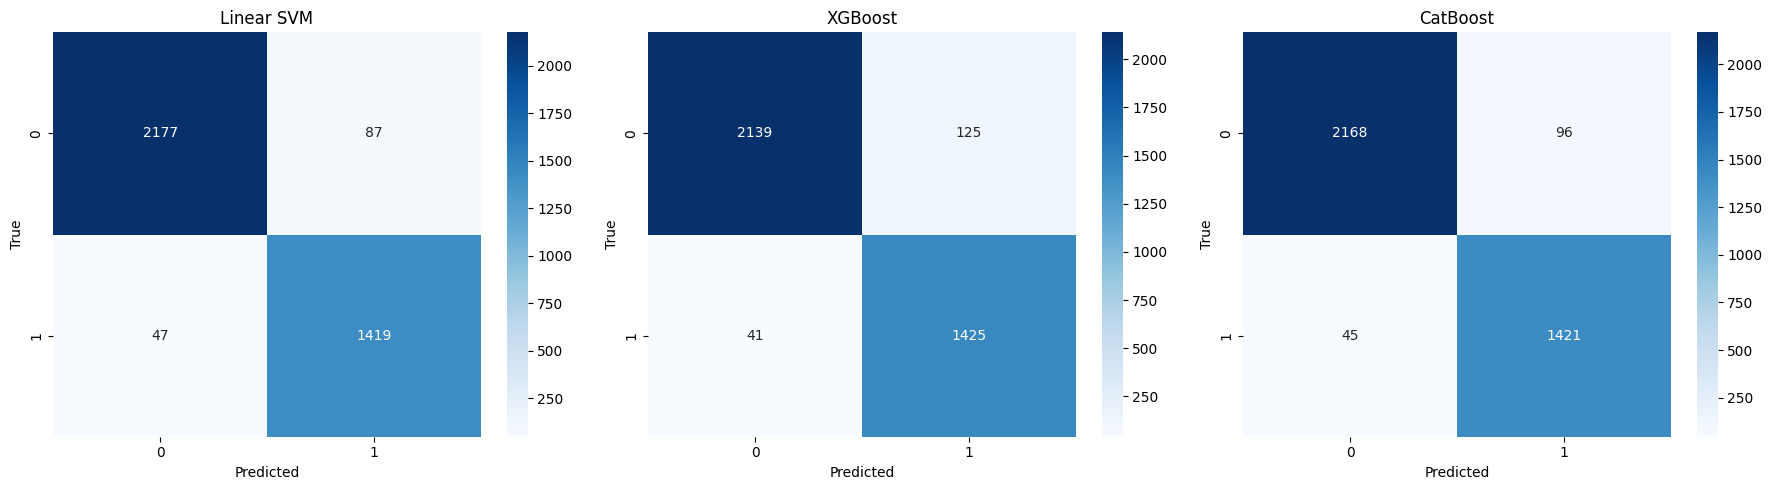

In [13]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

models_dict = {
    "Linear SVM": svm,
    "XGBoost": xgb_model,
    "CatBoost": cat
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models_dict.items()):
    if name == "XGBoost":
        y_pred = (model.predict(dtest) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test_final)

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


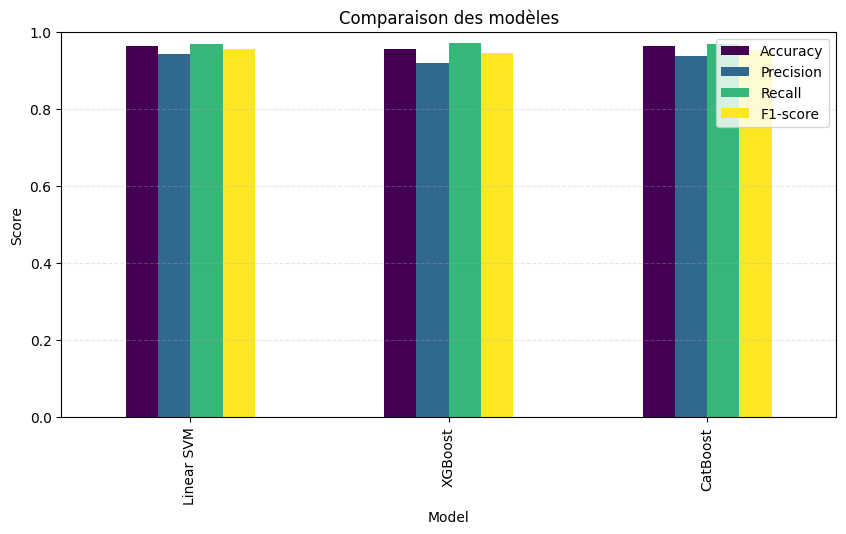

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

scores = []

for name, model in models_dict.items():
    if name == "XGBoost":
        y_pred = (model.predict(dtest) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test_final)

    scores.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    })

scores_df = pd.DataFrame(scores)
scores_df = scores_df.set_index("Model")

scores_df.plot(kind="bar", figsize=(10,5), colormap="viridis")
plt.title("Comparaison des modèles")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


### Comparaison Modèles

In [15]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, balanced_accuracy_score
)
import time
import pandas as pd

results = []

# --- fonctions de mesure ---
def evaluate_model(name, model, X_test, y_test, dtest=None):
    start_pred = time.time()

    if name == "XGBoost":
        y_pred_proba = model.predict(dtest)
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:,1]
        else:
            y_pred_proba = y_pred  # fallback

    pred_time = time.time() - start_pred

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
        "Prediction Time (s)": pred_time
    }


models_dict = {
    "Linear SVM": svm,
    "XGBoost": xgb_model,
    "CatBoost": cat
}

for name, model in models_dict.items():
    if name == "XGBoost":
        res = evaluate_model(name, model, X_test_final, y_test, dtest)
    else:
        res = evaluate_model(name, model, X_test_final, y_test)
    results.append(res)

df_results = pd.DataFrame(results)
df_results


,Model,Accuracy,Precision,Recall,F1-score,Balanced Acc,ROC-AUC,Prediction Time (s)
0,Linear SVM,0.964075,0.942231,0.967940,0.954913,0.964756,0.964756,0.000000
1,XGBoost,0.955496,0.919355,0.972033,0.944960,0.958410,0.992049,0.000000
2,CatBoost,0.962198,0.936717,0.969304,0.952732,0.963451,0.993884,0.056504


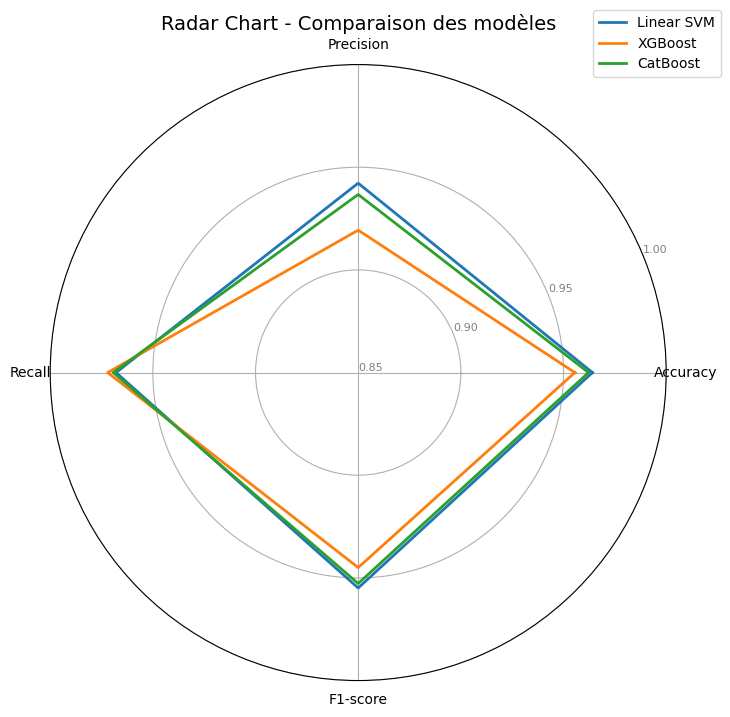

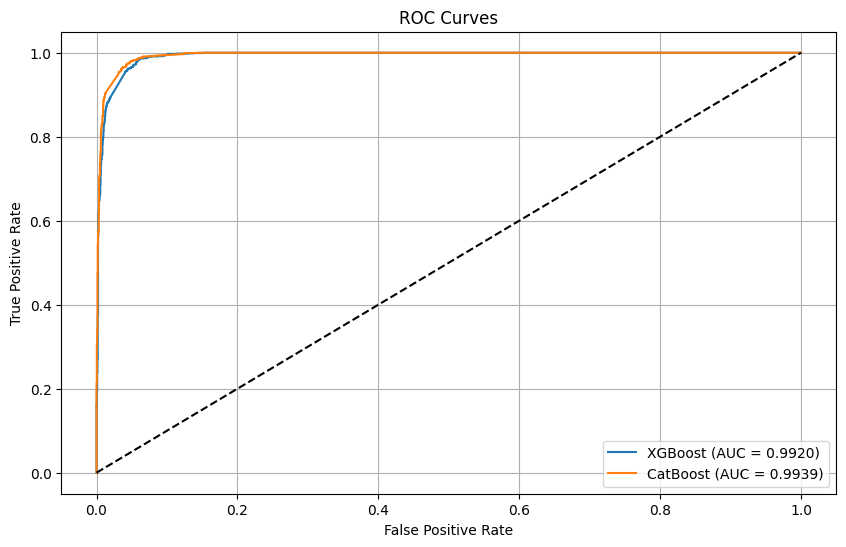

In [16]:
from math import pi
from matplotlib import pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]


plt.figure(figsize=(8, 8))

num_vars = len(metrics)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

for idx, row in df_results.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    plt.polar(angles, values, linewidth=2, label=row["Model"])

plt.xticks(angles[:-1], metrics)
plt.yticks([0.85, 0.9, 0.95, 1.0], color="grey", size=8)
plt.ylim(0.85, 1)

plt.title("Radar Chart - Comparaison des modèles", size=14)
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.show()


from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

for name, model in models_dict.items():
    if name == "XGBoost":
        y_proba = xgb_model.predict(dtest)
    else:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_final)[:, 1]
        else:
            continue  # SVM linéaire sans proba -> skip

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()


In [19]:
# Score combiné = moyenne pondérée F1 (70%) + ROC-AUC (30%)
df_results["GlobalScore"] = (
    df_results["F1-score"] * 0.7 +
    df_results["ROC-AUC"] * 0.3
)

best_model = df_results.sort_values("GlobalScore", ascending=False).iloc[0]

print("======== Meilleur modèle ========")
print(f"Modèle : {best_model['Model']}")
print(f"Score global : {best_model['GlobalScore']:.4f}")
print("-------------------------------------------")
print(best_model[["Accuracy","Precision","Recall","F1-score","ROC-AUC"]])


======== Meilleur modèle ========
Modèle : CatBoost
Score global : 0.9651
-------------------------------------------
Accuracy     0.962198
Precision    0.936717
Recall       0.969304
F1-score     0.952732
ROC-AUC      0.993884
Name: 2, dtype: object
